# Stock Forecasting (Demo) 
- This code demonstrates the process of pre-training an RNN model with stock data and forecasting stock prices
- The code is divided into 3 parts:
    - Pre-training the RNN model with the stock 300446
    - Continuing training the RNN model with the stock 688157
    - Forecasting the stock 600588


In [1]:
import datetime
import numpy as np
import pandas as pd
import torch
import stockcrawler
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error

In [2]:
def date_list(n):
    ds = []
    y = str(datetime.datetime.now().year)
    m = str(datetime.datetime.now().month)
    d = str(datetime.datetime.now().day)
    dates = pd.date_range(start=y + "-" + m + "-" + d, periods=n, freq="D")
    for date in dates:
        ds.append(datetime.datetime.strptime(str(date), "%Y-%m-%d %M:%H:%S"))
    return ds



- This function returns a list of dates starting from today, with n days in the future 
- Param n: number of days to forecast
- Returns: list of dates

In [3]:
def save_to_xlsx(code):
    strlist=stockcrawler.get_url(code)
    stockcrawler.get_data(strlist,code)

- This function saves stock data to an excel file
- Param code: stock code

In [4]:
def read_from_excel(file, n, train_end, columns):  
    """  
    从Excel读取股票数据  
    :param file: 文件名  
    :param n: 时间序列长度  
    :param train_end: 划分训练集和测试集索引  
    :param columns: 需要的列  
    :return: df_train, df_test, df, dates 训练集，测试集，所有数据，时间索引  
    """  
    df = pd.read_excel(file)  # 使用 read_excel 方法读取数据  

    df = df.sort_values("date")  # 按照日期排序  

    df_trade_date = df["date"]  # 获取日期列作为时间索引  

    df = df[columns]  # 选择需要的列  

    # 替换 0 值  
    # df[columns] = replace_zeros_with_neighbors(df[columns].values)  
    
    # 丢弃包含0值的行  
    #df = df[(df != 0).all(axis=1)]  # 只保留所有列均不为0的行  

    dates = []  
    for date in df_trade_date.tolist():  
        dates.append(datetime.datetime.strptime(str(date), "%Y-%m-%d"))  

    if train_end == 0:  
        train_end = len(df)  

    df_train, df_test = df[:train_end], df[train_end - n:]  

    return df_train, df_test, df, dates  

- This function reads stock data from an excel file
- Param file: file name
- Param n: length of time series
- Param train_end: index to split training and testing data
- Returns: df_train, df_test, df, dates

In [5]:
def series_data(df, n):
    """
    将数据组装成时间序列
    :param df: DataFrame对像
    :param n: 时间序列长度
    :return: data, label 数据和标签的numpy数组对象
    """
    data = []
    label = []
    for i in range(len(df) - n):
        d = df[i:n + i].values
        l = df[n + i:n + i + 1][["open", "high", "low", "close"]].values

        data.append(d)
        label.append(l)

    return np.array(data), np.array(label)


- This function assembles data into time series
- Param df: DataFrame object
- Param n: length of time series
- Returns: data, label

In [6]:
def standard_scaler(df):
    """
    数据标准化处理
    :param df: DataFrame对象
    :return: df,mean_map,std_map 标准化后的DataFrame对象，每列的均值，每列的标准差
    """
    df = df.copy()
    mean_map = {}
    std_map = {}
    for idx in df:
        mean = df[idx].mean()
        std = df[idx].std()
        for i in df.index:
            df.loc[i, idx] -= mean
            df.loc[i, idx] /= std
        mean_map[idx] = mean
        std_map[idx] = std
    return df, mean_map, std_map

- This function standardizes data
- Param df: DataFrame object
- Returns: df, mean_map, std_map

In [7]:
def get_row_count(file):
    df = pd.read_excel(file)
    row_count = len(df)-1
    print("数据集数量为:",row_count,"条")
    train_portion=float(0.7)
    while train_portion>1 or train_portion<0:
        print("输入错误，请重新输入")
        train_portion=float(input("选择测试集和训练集的比例划分,输入测试集所占比例(0-1):"))

    return row_count*train_portion

- This function returns the number of rows in a dataset
- Param file: file name
- Returns: row_count

In [8]:

def replace_zeros_with_neighbors(arr):  
    """  
    替换数组中的0值，使用上下邻居的平均值  
    :param arr: 输入数组  
    :return: 替换后的数组  
    """  
    arr = arr.copy()  # 复制数组以避免修改原始数据  

    for i in range(arr.shape[0]):  # 遍历每一行  
        for idx in range(arr.shape[1]):  # 遍历每一列  
            if arr[i, idx] == 0:  
                valid_neighbors = []  

                # 向上查找  
                for up in range(i + 1, arr.shape[0]):  
                    if arr[up, idx] != 0:  
                        valid_neighbors.append(arr[up, idx])  
                        break  

                # 向下查找  
                for down in range(i - 1, -1, -1):  
                    if arr[down, idx] != 0:  
                        valid_neighbors.append(arr[down, idx])  
                        break  

                # 如果找到了有效邻居，则替换  
                if valid_neighbors:  
                    arr[i, idx] = np.mean(valid_neighbors)  
                else:  
                    arr[i, idx] = np.nan  # 如果没有有效值，设为NaN  

    # 处理 NaN  
    for idx in range(arr.shape[1]):  
        # 计算非零值的平均  
        non_zero_mean = np.nanmean(arr[:, idx][arr[:, idx] != 0])  
        arr[:, idx] = np.where(np.isnan(arr[:, idx]), non_zero_mean, arr[:, idx])  # 替换 NaN  

    return arr  

In [9]:
def show(code, train_end, n, columns, p):
    """
    画图显示，并预测下一个交易日的开盘价，最高价，收盘价，最低价
    :param code: 股票代码
    :param train_end: 训练集测试集分割下标
    :param n: 时间序列
    :return:
    """
    rnn = torch.load(code+".pkl")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    rnn.to(device)
    df_train, df_test, df, dates = read_from_excel(code + "_history.xlsx", n, train_end, columns)
    if train_end == 0:
        train_end = len(df)
    elif train_end < 0:
        train_end = len(df) + train_end
    # 进行验证并画图显示
    train = []
    test = []
    predict = []
    predict_dates = date_list(p)

    df_all_normal, mean, std = standard_scaler(df)
    means = np.array([mean["open"], mean["high"], mean["low"], mean["close"]])
    stds = np.array([std["open"], std["high"], std["low"], std["close"]])
    ts_all_normal = torch.Tensor(df_all_normal.values)
    predict_normal = df_all_normal[-n:].values.tolist()

    for i in range(n, len(df)):
        x = ts_all_normal[i - n:i].to(device)
        x = torch.unsqueeze(x, dim=0)
        y = rnn(x).to(device)
        y = torch.squeeze(y).detach().cpu().numpy()[-1, :]

        yy = y * stds + means
        if i < train_end:
            train.append(yy)
        else:
            test.append(yy)

    for i in range(p):
        ts_predict_normal = torch.Tensor(predict_normal)
        x = ts_predict_normal[i:i + n].to(device)
        x = torch.unsqueeze(x, dim=0)
        y = rnn(x).to(device)
        y = torch.squeeze(y).detach().cpu().numpy()[-1, :]
        yy = y * stds + means
        predict.append(yy)
        predict_normal.append(y.tolist())

    for i in range(len(predict)):
        print("预测第{}天的开盘价:{:.2f} 最高价:{:.2f} 最低价:{:.2f} 收盘价:{:.2f}".format(i + 1, predict[i][0], predict[i][1],
                                                                           predict[i][2], predict[i][3]))

    train = np.array(train)
    test = np.array(test)
    predict = np.array(predict)
    
    # 计算绝对误差和相对误差
    train_true = df_train[["open", "high", "low", "close"]].values[n:]
    test_true = df_test[["open", "high", "low", "close"]].values[n:]

   


    train_mae = mean_absolute_error(train_true, train)
    test_mae = mean_absolute_error(test_true, test)
    
    
    # train_mask = np.all(train_true != 0, axis=1)  # 确保整行没有0  
    # test_mask = np.all(test_true != 0, axis=1)     # 确保整行没有0  
    # 
    # train_relative_error = np.mean(np.abs((train[train_mask] - train_true[train_mask]) / train_true[train_mask]))  
    # test_relative_error = np.mean(np.abs((test[test_mask] - test_true[test_mask]) / test_true[test_mask]))  


    
    train_relative_error = np.mean(np.abs((train_true - train) / train_true))  
    test_relative_error = np.mean(np.abs((test_true - test) / test_true))  

    # 计算相对误差，忽略train_true中的0值  
    # train_relative_error = np.mean(np.abs((train_true[train_true != 0] - train[train_true != 0]) / train_true[train_true != 0]))  
    # test_relative_error = np.mean(np.abs((test_true[test_true != 0] - test[test_true != 0]) / test_true[test_true != 0]))  
    
    # 将 train_true 中的 0 替换为 1e-10  
    # train_true = np.where(train_true == 0, 1e-10, train_true)  
    # test_true = np.where(test_true == 0, 1e-10, test_true)  
    # train_relative_error = np.mean(np.abs((train_true - train) / train_true))  
    # test_relative_error = np.mean(np.abs((test_true - test) / test_true))  
    
    print(f'Train MAE: {train_mae}')
    print(f'Test MAE: {test_mae}')
    print(f'Train Relative Error: {train_relative_error}')
    print(f'Test Relative Error: {test_relative_error}')
    plt.rcParams["font.sans-serif"] = ["KaiTi"]
    plt.rcParams["axes.unicode_minus"] = False

    plt.figure(1,figsize=(15, 10))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    plt.subplot(221)
    plt.plot(dates[n:train_end], train[:, 0], color="#ff0000", label="训练集", linewidth="1")
    if train_end != len(df):
        plt.plot(dates[train_end:], test[:, 0], color="#0000ff", label="测试集", linewidth="1")
    plt.plot(dates, df["open"], color="#00ff00", label="真实数据", linewidth="1",linestyle='dotted')
    plt.plot(predict_dates, predict[:, 0], color="#000000", label="预测数据", linewidth="1")
    plt.xlabel("时间")
    plt.ylabel("价格")
    plt.title("开盘价")
    plt.legend()

    plt.subplot(222)
    plt.plot(dates[n:train_end], train[:, 1], color="#ff0000", label="训练集", linewidth="1")
    if train_end != len(df):
        plt.plot(dates[train_end:], test[:, 1], color="#0000ff", label="测试集", linewidth="1")
    plt.plot(dates, df["high"], color="#00ff00", label="真实数据", linewidth="1",linestyle='dotted')
    plt.plot(predict_dates, predict[:, 1], color="#000000", label="预测数据", linewidth="1")
    plt.xlabel("时间")
    plt.ylabel("价格")
    plt.title("最高价")
    plt.legend()
    plt.xlim([dates[train_end-n], dates[-1]])  # 设置 x 轴显示范围
    # plt.ylim([df["open"].min(), df["open"].max()])  # 设置 y 轴显示范围

    plt.subplot(223)
    plt.plot(dates[n:train_end], train[:, 2], color="#ff0000", label="训练集", linewidth="1")
    if train_end != len(df):
        plt.plot(dates[train_end:], test[:, 2], color="#0000ff", label="测试集", linewidth="1")
    plt.plot(dates, df["low"], color="#00ff00", label="真实数据", linewidth="1",linestyle='dotted')
    plt.plot(predict_dates, predict[:, 2], color="#000000", label="预测数据", linewidth="1")
    plt.xlabel("时间")
    plt.ylabel("价格")
    plt.title("最低价")
    plt.legend()

    plt.subplot(224)
    plt.plot(dates[n:train_end], train[:, 3], color="#ff0000", label="训练集", linewidth="1")
    if train_end != len(df):
        plt.plot(dates[train_end:], test[:, 3], color="#0000ff", label="测试集", linewidth="1")
    plt.plot(dates, df["close"], color="#00ff00", label="真实数据", linewidth="1",linestyle='dotted')
    plt.plot(predict_dates, predict[:, 3], color="#000000", label="预测数据", linewidth="1")
    plt.xlabel("时间")
    plt.ylabel("价格")
    plt.title("收盘价")
    plt.legend()
    plt.show()


- This function displays the forecasted stock prices
- Param code: stock code that is being forecasted
- Param train_end: index to split training and testing data
- Param n: length of time series
- Param columns: feature columns to be forecasted
- Param p: number of days to forecast


In [10]:
class RNN(torch.nn.Module):
    def __init__(self, input_size):
        """
        循环神经网络实现，采用LSTM
        :param input_size: 输入的特征维度
        """
        super(RNN, self).__init__()
        self.rnn = torch.nn.LSTM(
            input_size=input_size,
            hidden_size=128,
            num_layers=2,
            batch_first=True
        )
        self.out = torch.nn.Sequential(
            torch.nn.Linear(128, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 4)
        )

    def forward(self, x):
        """
        前向传播
        :param x: 输入数据
        :return:
        """
        r_out, (h_n, h_c) = self.rnn(x, None)
        out = self.out(r_out)
        return out


- This class defines the RNN model
- Param input_size: input feature dimension
- forward: forward propagation
- Returns: out

In [11]:
class TrainSet(Dataset):
    def __init__(self, data, label):
        self.data, self.label = data.float(), label.float()

    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)

- This class defines the training dataset
- Param data: input data
- Param label: output label
- Returns: data, label

In [12]:
# 超参数
# 学习率
LR = 0.0001
# EPOCH大小
EPOCH = 50

if __name__ == "__main__":
    # 首次训练
    print("首次训练")
    first_stock_code = '300446'
    save_to_xlsx(first_stock_code)
    n = int(30)
    print("选择训练集长度")
    train_end=int(get_row_count(first_stock_code + "_history.xlsx"))
    #p = int(input("请输入预测天数:"))

    # 爬取和读取数据

    columns = ["open", "high", "low", "close"]
    df_train_first, df_test_first, df_first, dates_first = read_from_excel(first_stock_code + "_history.xlsx", n, train_end,
                                                                           columns)

    # 标准化处理
    df_train_normal_first, mean_first, std_first = standard_scaler(df_train_first)

    # 构建训练数据
    np_train_normal_first, np_label_normal_first = series_data(df_train_normal_first, n)

    # 转为 Tensor
    ts_train_normal_first = torch.Tensor(np_train_normal_first)
    ts_label_normal_first = torch.Tensor(np_label_normal_first)
    train_set_first = TrainSet(ts_train_normal_first, ts_label_normal_first)
    train_loader_first = DataLoader(train_set_first, batch_size=10, shuffle=False)

    # 初始化 RNN 模型
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    rnn = RNN(df_train_first.shape[1])
    rnn.to(device)

    # 训练模型
    optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, last_epoch=-1)
    loss_func = torch.nn.MSELoss()

    for step in range(EPOCH):
        for tx, ty in train_loader_first:
            tx, ty = tx.to(device), ty.to(device)
            output = rnn(tx)
            loss = loss_func(torch.squeeze(output[:, -1, :]), torch.squeeze(ty))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()
        print(f"第 {step + 1} 个 Epoch 的损失: {loss.item()}")

    # 保存模型
    torch.save(rnn,first_stock_code + "_model.pkl")
    print("第一支股票模型训练完成并保存。")

首次训练
正在获取数据...
选择训练集长度
数据集数量为: 2174 条
第 1 个 Epoch 的损失: 0.023299552500247955
第 2 个 Epoch 的损失: 0.0023083302658051252
第 3 个 Epoch 的损失: 0.015153622254729271
第 4 个 Epoch 的损失: 0.019789952784776688
第 5 个 Epoch 的损失: 0.016728632152080536
第 6 个 Epoch 的损失: 0.012287328951060772
第 7 个 Epoch 的损失: 0.009048564359545708
第 8 个 Epoch 的损失: 0.006939524784684181
第 9 个 Epoch 的损失: 0.0055543482303619385
第 10 个 Epoch 的损失: 0.004595165140926838
第 11 个 Epoch 的损失: 0.0004694986855611205
第 12 个 Epoch 的损失: 0.0003790912451222539
第 13 个 Epoch 的损失: 0.0003876745468005538
第 14 个 Epoch 的损失: 0.00041237520053982735
第 15 个 Epoch 的损失: 0.00044247155892662704
第 16 个 Epoch 的损失: 0.0004756158450618386
第 17 个 Epoch 的损失: 0.0005101909046061337
第 18 个 Epoch 的损失: 0.000545529299415648
第 19 个 Epoch 的损失: 0.0005809827707707882
第 20 个 Epoch 的损失: 0.0006160347256809473
第 21 个 Epoch 的损失: 0.0005558921257033944
第 22 个 Epoch 的损失: 0.0004677154356613755
第 23 个 Epoch 的损失: 0.0004056429897900671
第 24 个 Epoch 的损失: 0.000361357320798561
第 25 个 Epoch 的损失: 0

- This code pre-trains the RNN model with the 1st stock the user 
- The user is prompted to enter the stock code, sequence length, and training/test set split
- The model is trained and saved

In [13]:
# 二次训练
second_stock_code = '688157'
save_to_xlsx(second_stock_code)
n = int(30)
print("选择训练集长度")
train_end=int(get_row_count(second_stock_code + "_history.xlsx"))
#p = int(input("请输入预测天数:"))
# 爬取和读取数据

df_train_second, df_test_second, df_second, dates_second = read_from_excel(second_stock_code + "_history.xlsx", n,
                                                                           train_end, columns)

# 标准化处理
df_train_normal_second, mean_second, std_second = standard_scaler(df_train_second)

# 构建训练数据
np_train_normal_second, np_label_normal_second = series_data(df_train_normal_second, n)

# 转为 Tensor
ts_train_normal_second = torch.Tensor(np_train_normal_second)
ts_label_normal_second = torch.Tensor(np_label_normal_second)
train_set_second = TrainSet(ts_train_normal_second, ts_label_normal_second)
train_loader_second = DataLoader(train_set_second, batch_size=10, shuffle=False)

# 加载已训练模型参数
rnn=torch.load(first_stock_code + "_model.pkl")
# 重新初始化学习率
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
# 继续训练模型
for step in range(EPOCH):
    for tx, ty in train_loader_second:
        tx, ty = tx.to(device), ty.to(device)
        output = rnn(tx)
        loss = loss_func(torch.squeeze(output[:, -1, :]), torch.squeeze(ty))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"二次训练 - 第 {step + 1} 个 Epoch 的损失: {loss.item()}")

# 保存增量训练后的模型
torch.save(rnn,second_stock_code+"_model.pkl")
print("第二支股票增量训练完成并保存。")

正在获取数据...
选择训练集长度
数据集数量为: 987 条
二次训练 - 第 1 个 Epoch 的损失: 0.7511580586433411
二次训练 - 第 2 个 Epoch 的损失: 0.6288465857505798
二次训练 - 第 3 个 Epoch 的损失: 0.5189465880393982
二次训练 - 第 4 个 Epoch 的损失: 0.4283195436000824
二次训练 - 第 5 个 Epoch 的损失: 0.35678672790527344
二次训练 - 第 6 个 Epoch 的损失: 0.3015348017215729
二次训练 - 第 7 个 Epoch 的损失: 0.25878509879112244
二次训练 - 第 8 个 Epoch 的损失: 0.22507289052009583
二次训练 - 第 9 个 Epoch 的损失: 0.19798573851585388
二次训练 - 第 10 个 Epoch 的损失: 0.17583557963371277
二次训练 - 第 11 个 Epoch 的损失: 0.15753263235092163
二次训练 - 第 12 个 Epoch 的损失: 0.14227785170078278
二次训练 - 第 13 个 Epoch 的损失: 0.129608616232872
二次训练 - 第 14 个 Epoch 的损失: 0.11914173513650894
二次训练 - 第 15 个 Epoch 的损失: 0.1106434017419815
二次训练 - 第 16 个 Epoch 的损失: 0.10383085161447525
二次训练 - 第 17 个 Epoch 的损失: 0.09833615273237228
二次训练 - 第 18 个 Epoch 的损失: 0.09387633204460144
二次训练 - 第 19 个 Epoch 的损失: 0.09012138843536377
二次训练 - 第 20 个 Epoch 的损失: 0.08683153241872787
二次训练 - 第 21 个 Epoch 的损失: 0.08380022644996643
二次训练 - 第 22 个 Epoch 的损失: 0.0809080526232

- This code continues training the previous RNN model with the 2nd stock
- The learning rate of the model is re-initialized
- The user is prompted to enter the stock code, sequence length, and training/test set split for the 2nd time
- The model is trained and saved again

预测
正在获取数据...
数据集数量为: 5155 条
三次训练-第 1 个 Epoch 的损失: 0.035629332065582275
三次训练-第 2 个 Epoch 的损失: 0.02286132425069809
三次训练-第 3 个 Epoch 的损失: 0.021563906222581863
三次训练-第 4 个 Epoch 的损失: 0.0228279996663332
三次训练-第 5 个 Epoch 的损失: 0.02300630882382393
三次训练-第 6 个 Epoch 的损失: 0.022925499826669693
三次训练-第 7 个 Epoch 的损失: 0.02228795923292637
三次训练-第 8 个 Epoch 的损失: 0.02007664367556572
三次训练-第 9 个 Epoch 的损失: 0.018704287707805634
三次训练-第 10 个 Epoch 的损失: 0.01700504869222641
三次训练-第 11 个 Epoch 的损失: 0.016351208090782166
三次训练-第 12 个 Epoch 的损失: 0.016513876616954803
三次训练-第 13 个 Epoch 的损失: 0.015823571011424065
三次训练-第 14 个 Epoch 的损失: 0.01673981547355652
三次训练-第 15 个 Epoch 的损失: 0.017485352233052254
三次训练-第 16 个 Epoch 的损失: 0.016391552984714508
三次训练-第 17 个 Epoch 的损失: 0.015924489125609398
三次训练-第 18 个 Epoch 的损失: 0.01600072532892227
三次训练-第 19 个 Epoch 的损失: 0.015529118478298187
三次训练-第 20 个 Epoch 的损失: 0.016550801694393158
三次训练-第 21 个 Epoch 的损失: 0.016789762303233147
三次训练-第 22 个 Epoch 的损失: 0.01718464121222496
三次训练-第 23 个 Epoch 的损失: 

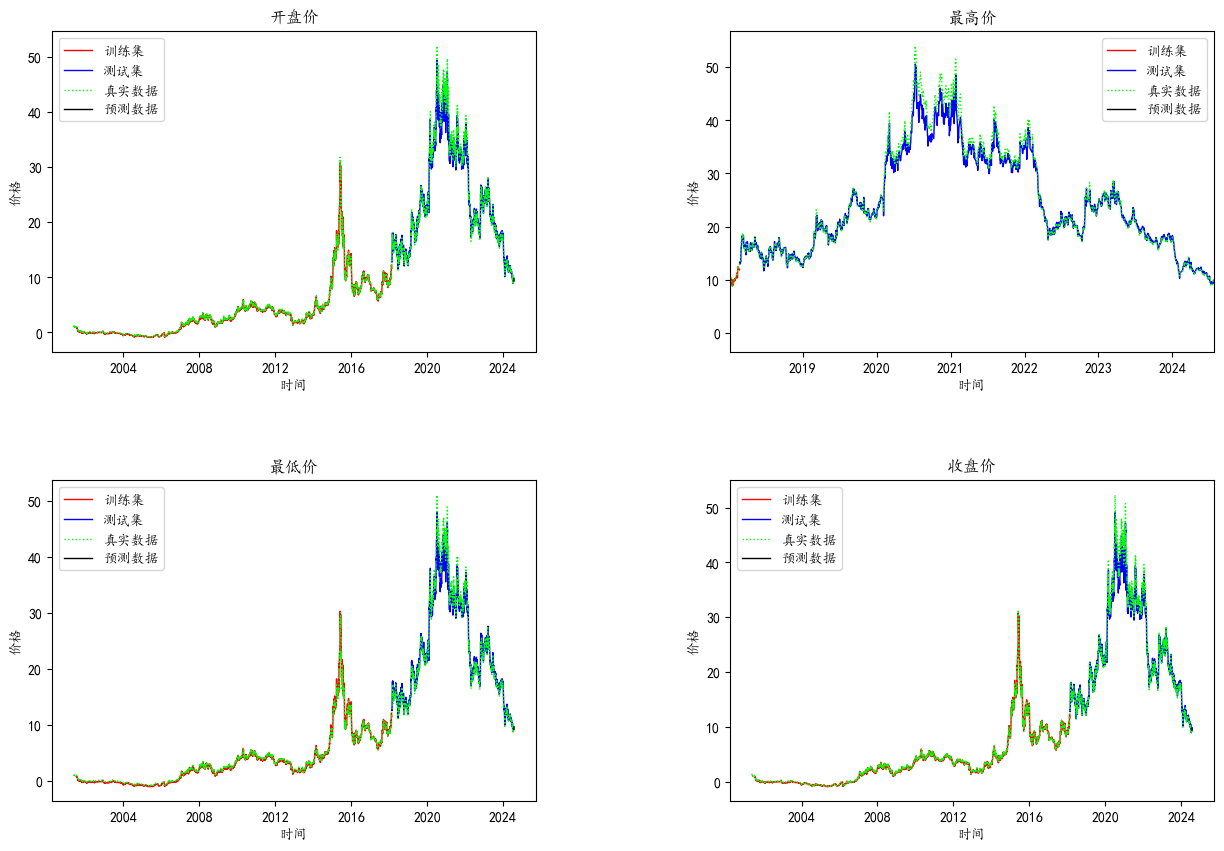

In [14]:
 # 预测
print("预测")
code='600588'
save_to_xlsx(code)
n = int(30)

train_end = int(get_row_count(code + "_history.xlsx"))
p = int(7)
# 爬取和读取数据

#df_predict, _, _, _ = read_from_excel(code + "_history.xlsx", n, 0, columns)
df_train, df_test, df, dates = read_from_excel(code + "_history.xlsx", n, train_end, columns)


# 将数据标准化或归一化处理
df_train_normal, mean, std = standard_scaler(df_train)
# 将数据组装成时间序列
np_train_normal, np_label_normal = series_data(df_train_normal, n)
# 将数据转成Tensor对象，并保存到DataLoader里
ts_train_normal = torch.Tensor(np_train_normal)
ts_label_normal = torch.Tensor(np_label_normal)
train_set = TrainSet(ts_train_normal, ts_label_normal)
train_loader = DataLoader(train_set, batch_size=10, shuffle=False)

# 加载已训练模型参数
rnn = torch.load(second_stock_code + "_model.pkl")
# 重新初始化学习率
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)

# 开始训练
for step in range(EPOCH):
    for tx, ty in train_loader:
        # 将数据加载到GPU中
        tx = tx.to(device)
        ty = ty.to(device)
        output = rnn(tx)
        # 计算损失
        loss = loss_func(torch.squeeze(output[:, -1, :]), torch.squeeze(ty))
        # 梯度清零
        optimizer.zero_grad()
        # 反向传播
        loss.backward()
        # 更新权重
        optimizer.step()
    scheduler.step()
    # 打印每个epoch的损失
    print(f"三次训练-第 {step + 1} 个 Epoch 的损失: {loss.item()}")

torch.save(rnn, code + ".pkl")


show(code, train_end, n, columns, p)


- 
- This code forecasts final predictions of ['open','high','low','close'] for the 3rd stock
- The user is prompted to enter the stock code, sequence length, and training/test set split and ***number of days to forecast***
- The model is trained and saved again
- The forecasted stock data is then displayed